In [1]:
import matplotlib.pyplot as plt  # show image
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
dtype = np.uint8
shape = (128,128)


In [4]:
pre_img_path="/kaggle/input/facepatternrecognizer/rawdata/"

In [5]:
face=pd.read_csv("/kaggle/input/facepatternrecognizer/faceLabel.csv")

In [6]:


# read image part
new=True
for  i in face["number"]:
    if new==True:
        path=pre_img_path+f"rawdata/{i}"
        new_element = np.fromfile(path, dtype=dtype).reshape(shape)
        dataset = tf.data.Dataset.from_tensor_slices([new_element])
        new=False
    else:
        path=pre_img_path+f"rawdata/{i}"
        data = np.fromfile(path, dtype=dtype).reshape(shape)
        new_element = tf.data.Dataset.from_tensor_slices([data])
        dataset = dataset.concatenate(new_element)
print(dataset)


<_ConcatenateDataset element_spec=TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None)>


In [7]:
face.head()

,number,sex,age,race,emotion,extra,sex_label,age_adult,age_child,age_senior,...,race_black,race_hispanic,race_other,race_white,emotion_funny,emotion_serious,emotion_smiling,race_label,emotion_label,age_label
0,1223,male,child,white,smiling,NaN,1,0,1,0,...,0,0,0,1,0,0,1,4,2,1
1,1224,male,child,white,serious,NaN,1,0,1,0,...,0,0,0,1,0,1,0,4,1,1
2,1225,male,child,white,smiling,NaN,1,0,1,0,...,0,0,0,1,0,0,1,4,2,1
3,1226,male,child,white,smiling,NaN,1,0,1,0,...,0,0,0,1,0,0,1,4,2,1
4,1227,male,child,white,serious,NaN,1,0,1,0,...,0,0,0,1,0,1,0,4,1,1


In [8]:
def convert_image123(image):
    image = tf.expand_dims(image, axis=0)
    image = tf.expand_dims(image, axis=-1)
    return tf.tile(image, [1, 1, 1, 3])
dataset_ = dataset.map(convert_image123)

In [9]:
def convert_to_float(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image
dataset_float = dataset_.map(convert_to_float)

In [10]:
num_elements = tf.data.experimental.cardinality(dataset_).numpy()
print(f"The dataset has {num_elements} elements.")

The dataset has 3993 elements.


In [11]:
# label2fit={'sex':["sex_label"],
#       'race':["race_asian","race_black","race_hispanic","race_other","race_white"],
#       'emotion':["emotion_funny","emotion_serious","emotion_smiling"],
#       'age':["age_adult","age_child","age_senior","age_teen"],
#       }
label2fit={
    'sex': ["sex_label"],
    'race': ["race_label"],
    'emotion': ["emotion_label"],
    'age': ["age_label"]
}

In [12]:
race_classes={0:"race_asian",1:"race_black",2:"race_hispanic",3:"race_other",4:"race_white"}
emotion_classes = {0: "emotion_funny", 1: "emotion_serious", 2: "emotion_smiling"}
age_classes = {0: "age_adult", 1: "age_child", 2: "age_senior", 3: "age_teen"}
sex_classes={0:'male',1:"female"}

In [13]:
num_classes={"race":5,"emotion":3,"age":4,"sex":2}

In [14]:
race_tensor=tf.convert_to_tensor(face[label2fit['race']].values)
emotion_tensor=tf.convert_to_tensor(face[label2fit['emotion']].values)
age_tensor=tf.convert_to_tensor(face[label2fit['age']].values)
sex_tensor=tf.convert_to_tensor(face[label2fit['sex']].values)

In [15]:
label_tensor={"race":race_tensor,"emotion":emotion_tensor,"age":age_tensor,"sex":sex_tensor}

In [16]:
# 首先，创建一个只包含 label_tensor 的数据集
label_dataset = tf.data.Dataset.from_tensor_slices((label_tensor['sex'], label_tensor['race'], label_tensor['emotion'], label_tensor['age']))
# label_dataset = tf.data.Dataset.from_tensor_slices((label_tensor['sex'], label_tensor['race'], label_tensor['emotion']))

# 然后，使用 tf.data.Dataset.zip 方法将 dataset_float 和 label_dataset 合并
dataset = tf.data.Dataset.zip((dataset_float, label_dataset))

# 最后，使用 tf.data.Dataset.map 方法将每个元素转换为所需的形式
def map_fn(x, labels):
    return (x, *labels)

dataset = dataset.map(map_fn)

In [17]:
print(dataset)

<_MapDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [18]:
# split train and test sets
# 计算训练集大小（例如，80% 的数据用于训练）
train_size = int(num_elements * 0.85)

# 使用 take 方法获取训练集
ds_train = dataset.take(train_size)

# 使用 skip 方法获取测试集
ds_valid = dataset.skip(train_size)

In [19]:
print(ds_valid)

<_SkipDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [20]:
def map_fn(image, sex, race, emotion, age):
    #     return image, {'sex_output': sex, 'race_output': race, 'emotion_output': emotion, 'age_output': age}
        return image, {'sex_output': sex, 'emotion_output': emotion}
# def map_fn(image, sex, race, emotion):
#     return image, {'sex_output': sex, 'race_output': race, 'emotion_output': emotion}
train_dataset = ds_train.map(map_fn)
valid_dataset = ds_valid.map(map_fn)

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = (
    train_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid_dataset = (
    valid_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [23]:
print(ds_valid)

<_PrefetchDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [24]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), {'sex_output': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'emotion_output': TensorSpec(shape=(1,), dtype=tf.int64, name=None)})>


# 1) Define Pretrained Base #

Now that you have a pretrained base to do our feature extraction, decide whether this base should be trainable or not.

In [25]:
import tensorflow_hub as hub

# 3) Train #


In [26]:
pretrained_base = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5")

f1_score

In [27]:
from keras import backend as K

def f1_score(y_true, y_pred):
    # Calculate the true positives, false positives, and false negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_score

ConfusionMatrix

In [28]:
from tensorflow.keras.metrics import Metric

class ConfusionMatrix(Metric):
    def __init__(self, num_classes, name='confusion_matrix', **kwargs):
        super(ConfusionMatrix, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_cm = self.add_weight(name='total_cm', shape=(num_classes, num_classes), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        current_cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, weights=sample_weight)
        return self.total_cm.assign_add(current_cm)

    def result(self):
        return self.total_cm

    def reset_states(self):
        self.total_cm.assign(tf.zeros((self.num_classes, self.num_classes)))

In [29]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
feature_extractor=keras.Sequential([
  layers.Conv2D(filters=32,kernel_size=(5,5),strides=1,padding="valid",input_shape=(128,128,3)),
  layers.MaxPooling2D(pool_size=(3,3),strides=2),
  layers.Conv2D(filters=64,kernel_size=(4,4),strides=1,padding="same"),
  layers.MaxPooling2D(pool_size=(3,3),strides=2),
  layers.Conv2D(filters=128,kernel_size=(5,5),strides=1,padding="valid"),
  layers.MaxPooling2D(pool_size=(3,3),strides=2),
  layers.Flatten(),
])

input = Input(shape=(128, 128, 3))

# x = feature_extractor(input)
x = pretrained_base(input)

# x = Dense(2048,activation="elu")(x)
# x = Dropout(0.3)(x)
# x = Dense(1024,activation="relu")(x)
# x = Dropout(0.3)(x)

x_sex= Dense(500,activation="relu")(x)
sex_output = Dense(1, activation='sigmoid', name='sex_output')(x_sex)

x_emotion= Dense(500,activation="relu")(x)
emotion_output = Dense(num_classes["emotion"], activation='softmax', name='emotion_output')(x_emotion)

x_race= Dense(500,activation="relu")(x)
race_output= Dense(num_classes["race"],activation='softmax',name='race_output')(x_race)

x_age= Dense(500,activation="relu")(x)
age_output= Dense(num_classes["age"],activation='softmax',name='age_output')(x_age)

# model=Model(inputs=input,outputs=[sex_output,emotion_output,race_output,age_output])
model=Model(inputs=input,outputs=[sex_output,emotion_output])

In [30]:
model.compile(optimizer='nadam',
#               loss={'sex_output': 'binary_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy','race_output':'sparse_categorical_crossentropy','age_output':'sparse_categorical_crossentropy'},
              loss={'sex_output': 'binary_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])


In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint('model-{epoch:02d}.h5', save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

In [36]:
# history = model.fit(    image_train,
#               {'sex_output': sex_train, 'emotion_output': emotion_train,'race_output':race_train,'age_output':age_train},
#               validation_data=(image_valid, {'sex_output': sex_valid, 'emotion_output': emotion_valid,'race_output':race_valid,'age_output':age_valid}),
#               callbacks=[checkpoint,early_stopping],
#               # metrics=["accuracy",f1_score],
#               epochs=10)
history = model.fit(train_dataset, validation_data=valid_dataset, callbacks=[checkpoint, early_stopping],epochs=100)

Epoch 1/100
3394/3394 [==============================] - 31s 9ms/step - loss: 1.0076 - sex_output_loss: 0.3618 - emotion_output_loss: 0.6458 - sex_output_accuracy: 0.8751 - emotion_output_accuracy: 0.7163 - val_loss: 1.6405 - val_sex_output_loss: 1.0101 - val_emotion_output_loss: 0.6304 - val_sex_output_accuracy: 0.6444 - val_emotion_output_accuracy: 0.7028
Epoch 2/100
3394/3394 [==============================] - 33s 10ms/step - loss: 0.9254 - sex_output_loss: 0.3127 - emotion_output_loss: 0.6127 - sex_output_accuracy: 0.8851 - emotion_output_accuracy: 0.7204 - val_loss: 1.7913 - val_sex_output_loss: 1.1684 - val_emotion_output_loss: 0.6229 - val_sex_output_accuracy: 0.6427 - val_emotion_output_accuracy: 0.7229
Epoch 3/100
3394/3394 [==============================] - 32s 9ms/step - loss: 0.8894 - sex_output_loss: 0.2953 - emotion_output_loss: 0.5942 - sex_output_accuracy: 0.8880 - emotion_output_accuracy: 0.7413 - val_loss: 1.7939 - val_sex_output_loss: 1.1710 - val_emotion_output_loss

In [38]:
# model.build()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1024)         5607184     ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 500)          512500      ['keras_layer[0][0]']            
                                                                                                  
 dense_1 (Dense)                (None, 500)          512500      ['keras_layer[0][0]']        

Run the cell below to plot the loss and metric curves for this training run.

Best val_loss: 1.636129379272461


<Axes: >

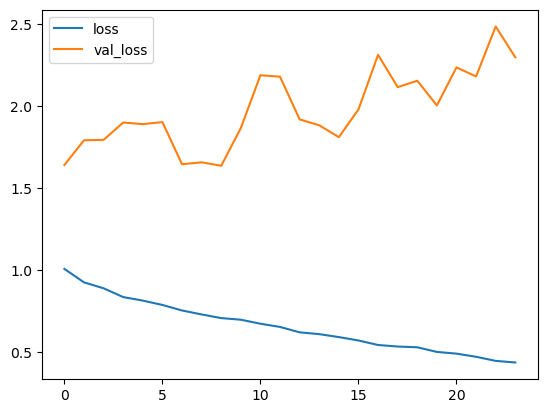

In [39]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
# best_accuracy = max(history.history['accuracy'])
# print('Best accuracy:', best_accuracy)
# best_val_accuracy = max(history.history['val_accuracy'])
# print('Best val_accuracy:', best_val_accuracy)
best_val_loss = min(history.history['val_loss'])
print('Best val_loss:', best_val_loss)
history_frame.loc[:, ['loss', 'val_loss']].plot()
# history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
# history_frame.loc[:, ['f1_score','val_f1_score']].plot()

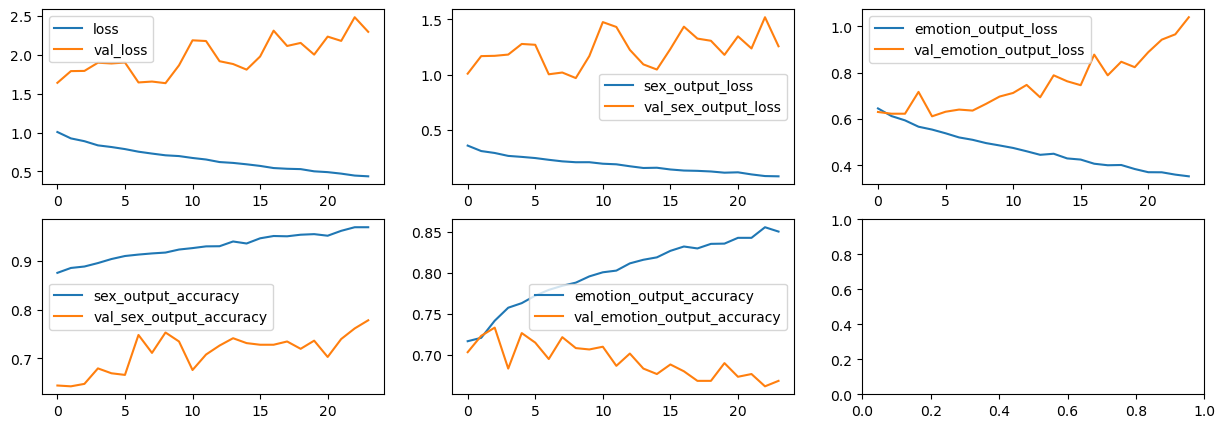

In [105]:
history_frame = pd.DataFrame(history.history)
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axs[0,0])
history_frame.loc[:, ['sex_output_loss', 'val_sex_output_loss']].plot(ax=axs[0,1])
history_frame.loc[:, ['emotion_output_loss', 'val_emotion_output_loss']].plot(ax=axs[0,2])
history_frame.loc[:,['sex_output_accuracy','val_sex_output_accuracy']].plot(ax=axs[1,0])
history_frame.loc[:,['emotion_output_accuracy','val_emotion_output_accuracy']].plot(ax=axs[1,1])
plt.show()

In [101]:
def split_labels(features,sex,race,emotion,age):
    return features,sex,emotion

In [102]:
model.evaluate(ds_valid.map(split_labels))

599/599 [==============================] - 7s 6ms/step - loss: 5.3020 - sex_output_loss: 1.5789 - emotion_output_loss: 3.7231 - sex_output_accuracy: 0.7529 - emotion_output_accuracy: 0.3873


[5.301999568939209,
 1.5789070129394531,
 3.723095178604126,
 0.7529215216636658,
 0.3873121738433838]

ConfusionMatrix查看分类效果

In [37]:
def split_features_labels(features, labels):
    return features, labels

x_valid = ds_valid.map(lambda features, *labels: features)
y_valid = ds_valid.map(lambda features, *labels: labels)

In [46]:
def split_labels_sex(sex,race,emotion,age):
    return sex
def split_labels_emotion(sex,race,emotion,age):
    return emotion

In [47]:
sex_valid=y_valid.map(split_labels_sex)
emotion_valid=y_valid.map(split_labels_emotion)

In [48]:
sex_valid

<_MapDataset element_spec=TensorSpec(shape=(1,), dtype=tf.int64, name=None)>

In [ ]:
from tensorflow.keras import backend as K
data = np.concatenate([x for x in x_valid.as_numpy_iterator()], axis=0)
x_tensor = tf.convert_to_tensor(data)

In [49]:
y_pred = model.predict(x_valid)

599/599 [==============================] - 11s 6ms/step


In [85]:
y_pred_sex=y_pred[0]
y_pred_emotion=y_pred[1]

>性别分类

In [51]:
# 将数据集转换为 NumPy 数组
sex_valid_array = np.array(list(sex_valid.as_numpy_iterator()))

# 将 NumPy 数组转换为张量
label_sex = tf.convert_to_tensor(sex_valid_array)

In [68]:
y_pred_sex=tf.reshape(y_pred_sex,[599])

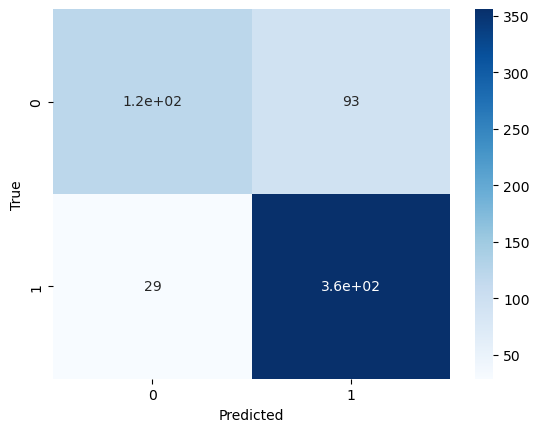

In [83]:
import seaborn as sns

y_pred_sex_1=[1 if i >0.88 else 0 for i in y_pred_sex]
confusion_matrix = tf.math.confusion_matrix(label_sex, y_pred_sex_1)
# 绘制混淆矩阵
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

>表情分类

In [96]:
# 将数据集转换为 NumPy 数组
emotion_valid_array = np.array(list(emotion_valid.as_numpy_iterator()))

# 将 NumPy 数组转换为张量
label_emo = tf.convert_to_tensor(emotion_valid_array)

In [92]:
y_pred_emo=tf.argmax(y_pred_emotion,axis=-1)

In [97]:
y_pred_emotion

array([[0.00182495, 0.93692607, 0.061249  ],
       [0.01397069, 0.8733065 , 0.11272283],
       [0.01074024, 0.9367879 , 0.05247183],
       ...,
       [0.03345191, 0.7240048 , 0.24254324],
       [0.0068937 , 0.43402228, 0.559084  ],
       [0.00221658, 0.0168756 , 0.98090786]], dtype=float32)

In [98]:
confusion_matrix = tf.math.confusion_matrix(label_emo, y_pred_emo)

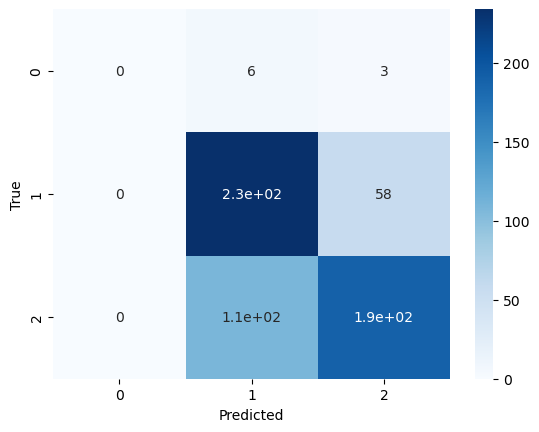

In [99]:
import seaborn as sns


# 绘制混淆矩阵
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [95]:
print(x_valid)

<_MapDataset element_spec=TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None)>


In [96]:
# 预测测试数据的标签
y_pred = model.predict(x_valid)
# y_pred_classes = tf.argmax(y_pred, axis=-1)
# y_true = np.concatenate([y for x, y in ds_valid], axis=0)
# y_valid_classes = tf.argmax(y_true, axis=-1)

599/599 [==============================] - 6s 6ms/step


In [98]:
# print(y_valid_classes)
print(y_pred[1])

[[1.92948850e-03 9.21427131e-01 7.66433626e-02]
 [8.14154185e-03 9.02163446e-01 8.96949396e-02]
 [1.99313890e-02 8.40346694e-01 1.39721945e-01]
 [2.07828265e-02 6.33976281e-01 3.45240891e-01]
 [1.46209020e-02 1.68475091e-01 8.16903949e-01]
 [1.62665583e-02 2.05203891e-01 7.78529584e-01]
 [3.09772808e-02 6.43646419e-01 3.25376242e-01]
 [2.43058391e-02 4.91633624e-01 4.84060496e-01]
 [4.34224643e-02 2.85717130e-01 6.70860469e-01]
 [7.02852830e-02 4.58304286e-01 4.71410424e-01]
 [5.31914234e-02 5.14833570e-01 4.31975007e-01]
 [5.43728843e-02 5.30543149e-01 4.15084004e-01]
 [4.82098870e-02 4.41118211e-01 5.10671914e-01]
 [2.82890908e-02 6.17487013e-01 3.54223937e-01]
 [5.65549669e-07 9.99976873e-01 2.25805488e-05]
 [2.68410910e-02 1.93811029e-01 7.79347837e-01]
 [7.15108588e-03 9.78162587e-02 8.95032704e-01]
 [3.63159329e-02 3.71010542e-01 5.92673481e-01]
 [3.15143690e-02 4.37137336e-01 5.31348288e-01]
 [1.41889295e-02 1.84803233e-01 8.01007807e-01]
 [5.49891545e-03 1.06434897e-01 8.880662

使用backend查看各个层的输出

In [ ]:
"""Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1001)         6633209     ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 500)          501000      ['keras_layer[0][0]']            
                                                                                                  
 dense_1 (Dense)                (None, 500)          501000      ['keras_layer[0][0]']            
                                                                                                  
 dense_2 (Dense)                (None, 500)          501000      ['keras_layer[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 500)          501000      ['keras_layer[0][0]']            
                                                                                                  
 sex_output (Dense)             (None, 1)            501         ['dense[0][0]']                  
                                                                                                  
 emotion_output (Dense)         (None, 3)            1503        ['dense_1[0][0]']                
                                                                                                  
 race_output (Dense)            (None, 5)            2505        ['dense_2[0][0]']                
                                                                                                  
 age_output (Dense)             (None, 4)            2004        ['dense_3[0][0]']                
                                                                                                  
==================================================================================================
Total params: 8,643,722
Trainable params: 2,010,513
Non-trainable params: 6,633,209
"""

In [100]:
from tensorflow.keras import backend as K

l=['input_1', 'keras_layer', 'dense', 'dense_1', 'dense_2', 'dense_3', 'sex_output', 'emotion_output', 'race_output', 'age_output']
#     0             1           2         3          4           5        6               7                8               9

In [110]:

# get_output = K.function([model.input], [model.layers[2].output])
get_output = K.function([model.input], [model.get_layer('emotion_output').output])
data = np.concatenate([x for x in x_valid.as_numpy_iterator()], axis=0)
x_tensor = tf.convert_to_tensor(data)
output = get_output([x_tensor])[0]

In [102]:
np.set_printoptions(threshold=np.inf)

In [111]:
print(output)

[[1.92948140e-03 9.21427250e-01 7.66432583e-02]
 [8.14156048e-03 9.02163327e-01 8.96950364e-02]
 [1.99312940e-02 8.40347111e-01 1.39721632e-01]
 [2.07827371e-02 6.33976460e-01 3.45240802e-01]
 [1.46207325e-02 1.68474346e-01 8.16904902e-01]
 [1.62665825e-02 2.05203980e-01 7.78529465e-01]
 [3.09771206e-02 6.43647134e-01 3.25375736e-01]
 [2.43057571e-02 4.91632551e-01 4.84061718e-01]
 [4.34223078e-02 2.85717279e-01 6.70860469e-01]
 [7.02855140e-02 4.58305210e-01 4.71409321e-01]
 [5.31916320e-02 5.14835060e-01 4.31973249e-01]
 [5.43728881e-02 5.30542791e-01 4.15084302e-01]
 [4.82098609e-02 4.41118091e-01 5.10672033e-01]
 [2.82891095e-02 6.17487192e-01 3.54223669e-01]
 [5.65544781e-07 9.99976873e-01 2.25804833e-05]
 [2.68411748e-02 1.93811104e-01 7.79347777e-01]
 [7.15109613e-03 9.78162587e-02 8.95032704e-01]
 [3.63161564e-02 3.71012807e-01 5.92671037e-01]
 [3.15142684e-02 4.37137395e-01 5.31348348e-01]
 [1.41889602e-02 1.84803709e-01 8.01007271e-01]
 [5.49893407e-03 1.06435068e-01 8.880659

导出模型

In [ ]:
# # 定义输入和输出
# inputs = {'input_image': model.input}
# outputs = {'output_scores': model.output}

# 导出模型
# tf.saved_model.save(model, pre_path+"modelTPU4multiClassfier(exceptAge)")

In [ ]:
# model_load=tf.saved_model.load(pre_path+"model4multiClassfier")

In [ ]:
# print(model_load.signatures.keys())

In [ ]:
# model.predict(ds_valid_)

In [ ]:
# for e in ds_valid:
#   print(e[1])
#   # print(e[0])
#   prediction=model_load.signatures['serving_default'](e[0])
#   print(prediction)
#   # print([1 if i>0.5 else 0 for i in l ])
#   break

In [ ]:
# print(prediction['dense_9'].numpy())

In [ ]:
# print([1 if i>0.5 else 0 for i in prediction['dense_9'].numpy()[0]])